In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import sys
sys.path.append("/Users/s2569857/Codes/DeepLearningTheory/core")
import model_generation as m_gen

In [2]:
np.random.seed(0)

# Configuration variables

In [3]:
# Number of networks to initialize with random parameters
number_of_networks = 1000

# input xgrid for which to produce the corresponding outputs
# reshape is needed for model input
ndat = 1000
input_xgrid = np.linspace(1.e-5, 1.0, num=ndat).reshape(-1,1)

# architecture
# Starting from the first deep layer (input dim = 1)
architecture = [28, 20, 1]

# activation function
act_func = "tanh"

# output function
output_func = "linear"

# Seed for the initialisation
seed = 32152315

# Generating the ensemble of models
Here the models are evaluated on the input `input_xgrid`.

In [4]:
def generate_sequential_model(outputs=1, 
                   input_layer=None, 
                   nlayers=2, 
                   units=[100,100],
                   train=False,
                   seed = 12345):
  """
  Create a tensorflow sequential model where all intermediate layers have the same size
  This function accepts an already constructed layer as the input.

  All hidden layers will have the same number of nodes for simplicity

  Arguments:
      outputs: int (default=1)
          number of output nodes (how many flavours are we training)
      input_layer: KerasTensor (default=None)
          if given, sets the input layer of the sequential model
      nlayers: int
          number of hidden layers of the network
      units: int
          number of nodes of every hidden layer in the network
      activation: str
          activation function to be used by the hidden layers (ex: 'tanh', 'sigmoid', 'linear')
  """
  if len(units) != nlayers:
      raise Exception("The length of units must match the number of layers.")
  
  model = tf.keras.models.Sequential(name="pdf")
  if input_layer is not None:
      model.add(input_layer)
  for layer in range(nlayers):
      model.add(tf.keras.layers.Dense(units[layer], 
                                      activation=act_func,
                                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed - layer),
                                      #tf.keras.initializers.HeNormal(seed = seed - nlayers)
                                      #bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=seed - layer)
                                      ),
      )
  model.add(tf.keras.layers.Dense(outputs, 
                                  activation=output_func, 
                                  kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed - nlayers)
                                  #tf.keras.initializers.HeNormal(seed = seed - nlayers),
                                  #bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=seed - nlayers)
                                  ))

  if train:
    opt = tf.keras.optimizers.Nadam()
    model.compile(opt, loss="mse")

  return model

In [5]:
def helper_plot(models, idx,ax, input_reshaped, color):
  pdf_cv = models[:,:,idx].mean(axis=0)
  pdf_std = models[:,:,idx].std(axis=0)
  cl_high = np.nanpercentile(models[:,:,idx], 84, axis=0)
  cl_low = np.nanpercentile(models[:,:,idx], 16, axis=0)

  # plot rep0 PDF
  ax.plot(input_reshaped, pdf_cv, color=color, lw=2, label="replica0")

  # 68%c.l. band
  ax.fill_between(input_reshaped, cl_low, cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

  # 1 std lines
  ax.plot(input_reshaped, (pdf_cv - pdf_std), alpha=0.4,ls="dashed", color=color)
  ax.plot(input_reshaped, (pdf_cv + pdf_std), alpha=0.4,ls="dashed", color=color, label="68%c.l.")

  ax.legend()

  ax.set_xscale("log")
  ax.set_yscale('symlog')
  ax.set_xlabel(r"$x$")
  ax.set_ylabel(rf"$f_{1}(x)$")
  ax.set_xlim(0.0,1)

In [6]:
nn_models = []
for _ in range(number_of_networks):
  nn_models.append(
    generate_sequential_model(
                    outputs=architecture[-1], 
                    nlayers=len(architecture)-1, 
                    units=architecture[:-1],
                    seed = seed + _),
  )

model_outputs = np.array(
    [nn_models[rep](tf.convert_to_tensor(input_xgrid)).numpy() for rep in range(len(nn_models))]
    )

# Plotting the functional priors

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_62364/2369294800.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0.0,1)


Text(0.5, 0.9, 'Ensemble with Nrep = 1000')

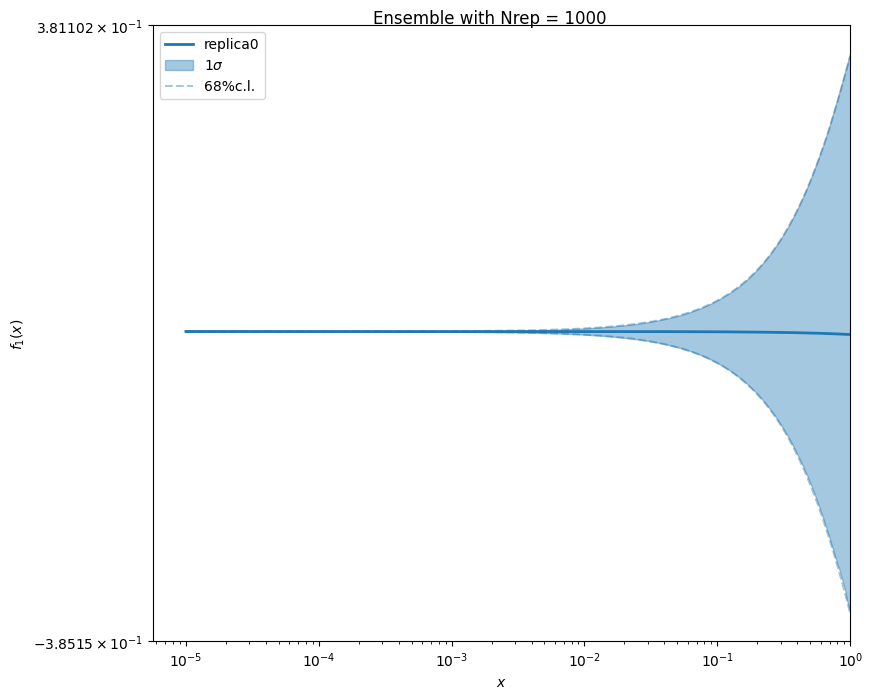

In [7]:
color = "C0"
input_reshaped = input_xgrid[:,0]
if architecture[-1] == 1:
  fig, axs = plt.subplots(figsize=(9, 8))
  helper_plot(model_outputs, 0, axs, input_reshaped, color)
else:
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 18))
  for out_idx, ax in enumerate(axs.flatten()):
    if out_idx <= architecture:
      helper_plot(model_outputs, out_idx, ax, input_reshaped, color)


fig.suptitle(rf"Ensemble with Nrep = {number_of_networks}", y = 0.9)

# Plots of different architectures

In [8]:
architectures_list = [
  [2,2,1],
  #[10,10,1],
  [25,20,1],
  [100,100,1]
]

colors = [
  "C0",
  #"C1",
  "C2",
  "C3"
]

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_62364/2699399770.py:40: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0.0,1)


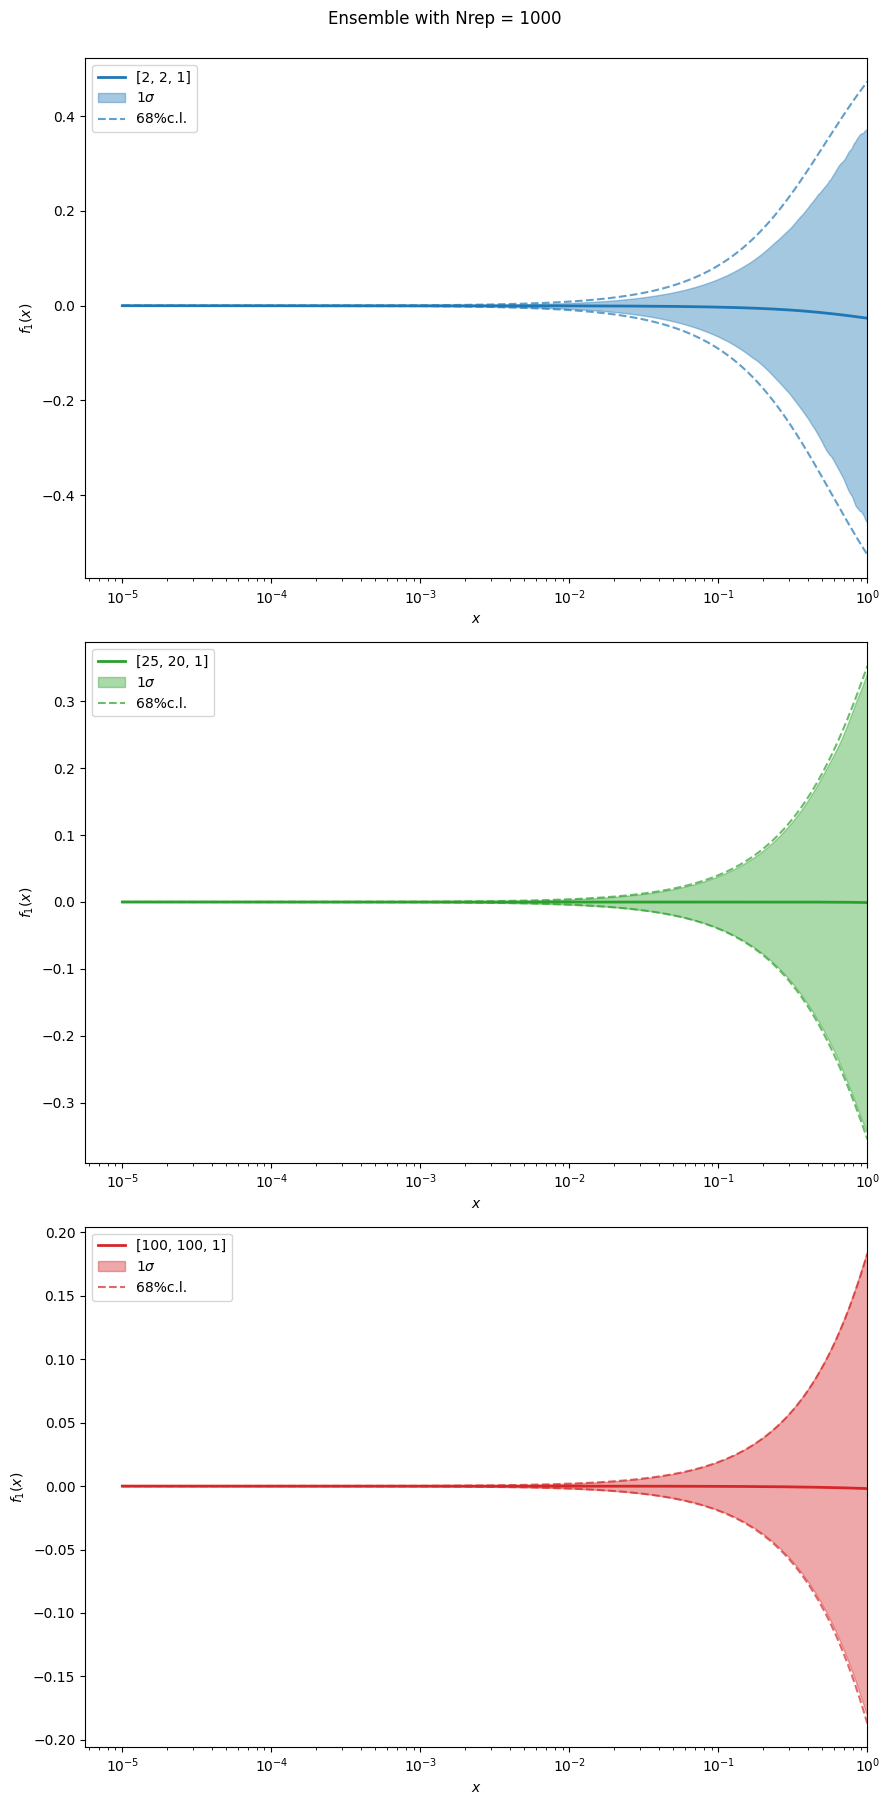

In [9]:
input_reshaped = input_xgrid[:,0]
fig, axs= plt.subplots(nrows=len(architectures_list), ncols=1, figsize=(9, 18))

for id, (arch, ax) in enumerate(zip(architectures_list, axs.flatten())):
  nn_models = []
  for _ in range(number_of_networks):
    nn_models.append(
      generate_sequential_model(
                      outputs=arch[-1], 
                      nlayers=len(arch)-1, 
                      units=arch[:-1],
                      seed = seed + _),
    )

  model_outputs = np.array(
      [nn_models[rep](tf.convert_to_tensor(input_xgrid)).numpy() for rep in range(len(nn_models))]
      )

  pdf_cv = model_outputs[:,:,0].mean(axis=0)
  pdf_std = model_outputs[:,:,0].std(axis=0)
  cl_high = np.nanpercentile(model_outputs[:,:,0], 84, axis=0)
  cl_low = np.nanpercentile(model_outputs[:,:,0], 16, axis=0)

  # plot rep0 PDF
  ax.plot(input_reshaped, pdf_cv, color=colors[id], lw=2, label=str(arch))

  # 68%c.l. band
  ax.fill_between(input_reshaped, cl_low, cl_high, alpha=0.4, color=colors[id], label=r"1$\sigma$")

  # 1 std lines
  ax.plot(input_reshaped, (pdf_cv - pdf_std), alpha=0.7,ls="dashed", color=colors[id])
  ax.plot(input_reshaped, (pdf_cv + pdf_std), alpha=0.7,ls="dashed", color=colors[id], label="68%c.l.")

  ax.legend()

  ax.set_xscale("log")
  #ax.set_yscale('symlog')
  ax.set_xlabel(r"$x$")
  ax.set_ylabel(rf"$f_{1}(x)$")
  ax.set_xlim(0.0,1)

fig.suptitle(rf"Ensemble with Nrep = {number_of_networks}", y = 1)
fig.tight_layout()
fig.savefig('gloriot_normal.png')

# Plots of functional priors for a NNPDF-like network
Neural networks with one-dimensional inputs $(x)$

In [15]:
nn_models = []
NNPDF_arch = [25, 20, 8]
for _ in range(number_of_networks):
  nn_models.append(
    generate_sequential_model(
                    outputs=NNPDF_arch[-1], 
                    nlayers=len(NNPDF_arch)-1, 
                    units=NNPDF_arch[:-1],
                    seed = seed + _),
  )

model_outputs = np.array(
    [nn_models[rep](tf.convert_to_tensor(input_xgrid)).numpy() for rep in range(len(nn_models))]
    )

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_62364/3322149173.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0.0,1)


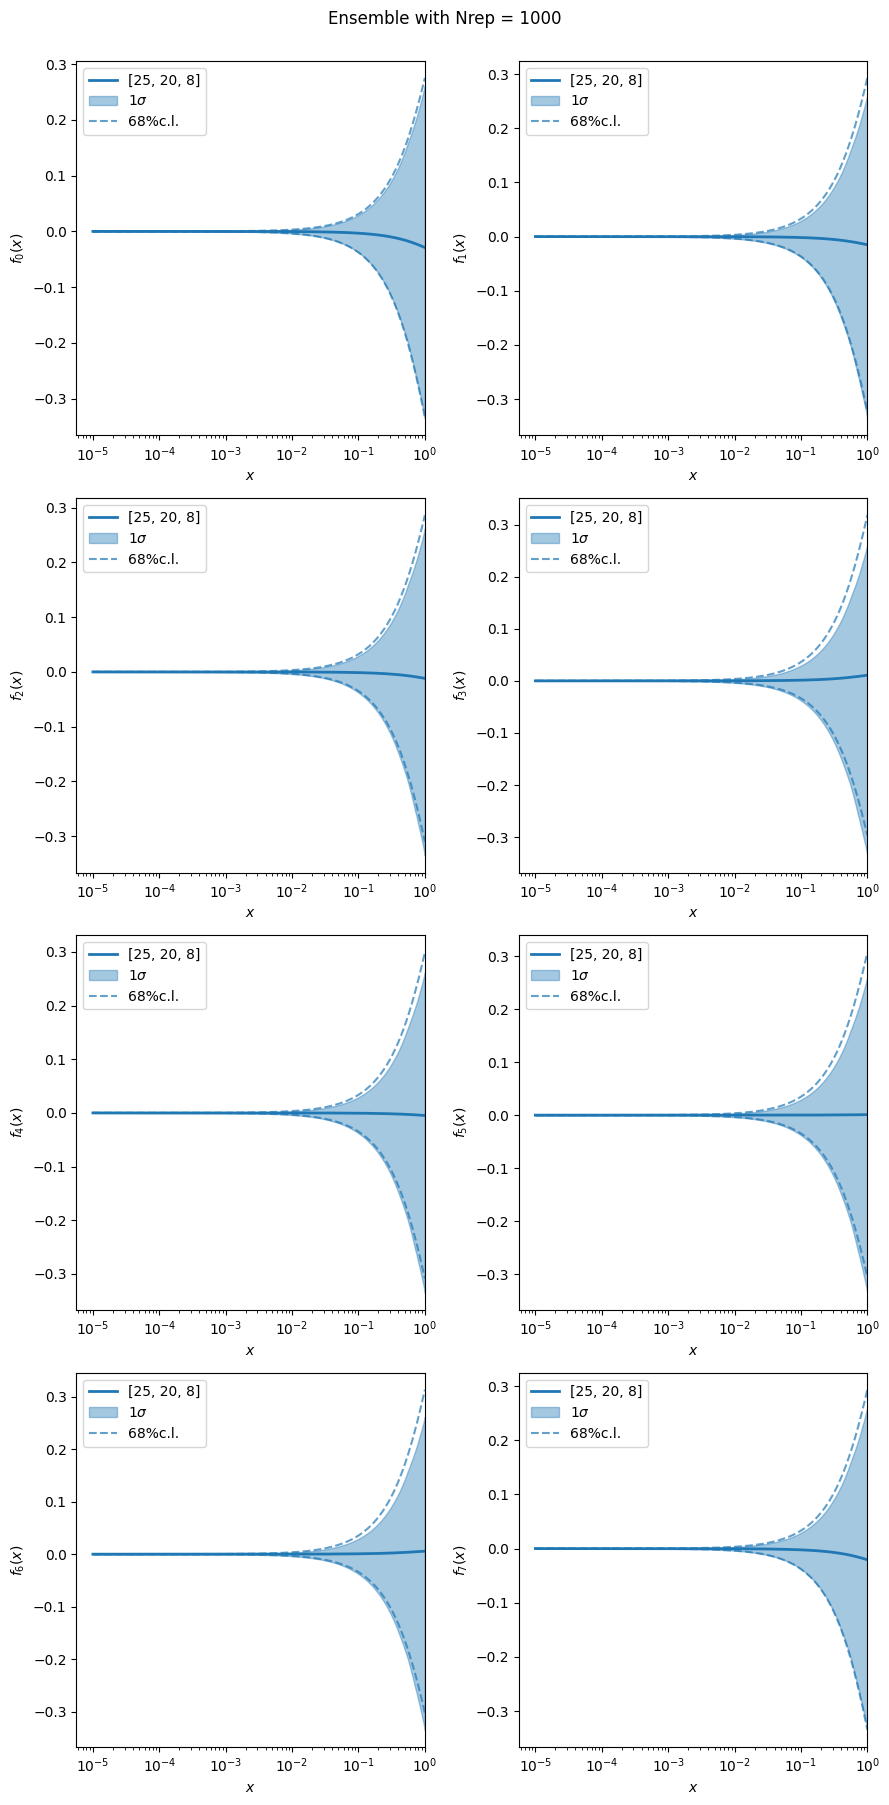

In [16]:
input_reshaped = input_xgrid[:,0]
fig, axs= plt.subplots(nrows=4, ncols=2, figsize=(9, 18))

for id, ax in enumerate(axs.flatten()):

  pdf_cv = model_outputs[:,:,id].mean(axis=0)
  pdf_std = model_outputs[:,:,id].std(axis=0)
  cl_high = np.nanpercentile(model_outputs[:,:,0], 84, axis=0)
  cl_low = np.nanpercentile(model_outputs[:,:,0], 16, axis=0)

  # plot rep0 PDF
  ax.plot(input_reshaped, pdf_cv, color=color, lw=2, label=str(NNPDF_arch))

  # 68%c.l. band
  ax.fill_between(input_reshaped, cl_low, cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

  # 1 std lines
  ax.plot(input_reshaped, (pdf_cv - pdf_std), alpha=0.7,ls="dashed", color=color)
  ax.plot(input_reshaped, (pdf_cv + pdf_std), alpha=0.7,ls="dashed", color=color, label="68%c.l.")

  ax.legend()

  ax.set_xscale("log")
  #ax.set_yscale('symlog')
  ax.set_xlabel(r"$x$")
  ax.set_ylabel(rf"$f_{id}(x)$")
  ax.set_xlim(0.0,1)
  
fig.suptitle(rf"Ensemble with Nrep = {number_of_networks}", y = 1)
fig.tight_layout()
fig.savefig('nnpdf_gloriot_normal.png')

## NNPDF priors with ($x$, $\log(x)$)

In [12]:
nn_models = []
NNPDF_arch = [25, 20, 8]

input_x_logx = np.zeros(shape=(ndat, 2))
input_x_logx[:,0] = input_xgrid[:,0]
input_x_logx[:,1] = np.log(input_xgrid[:,0])
for _ in range(number_of_networks):
  nn_models.append(
    generate_sequential_model(
                    input_layer=tf.keras.layers.Input(shape=(2,), batch_size=ndat),
                    outputs=NNPDF_arch[-1], 
                    nlayers=len(NNPDF_arch)-1, 
                    units=NNPDF_arch[:-1],
                    seed = seed + _),
  )

model_outputs = np.array(
    [nn_models[rep](tf.convert_to_tensor(input_x_logx)).numpy() for rep in range(len(nn_models))]
    )

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_62364/485260971.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0.0,1)


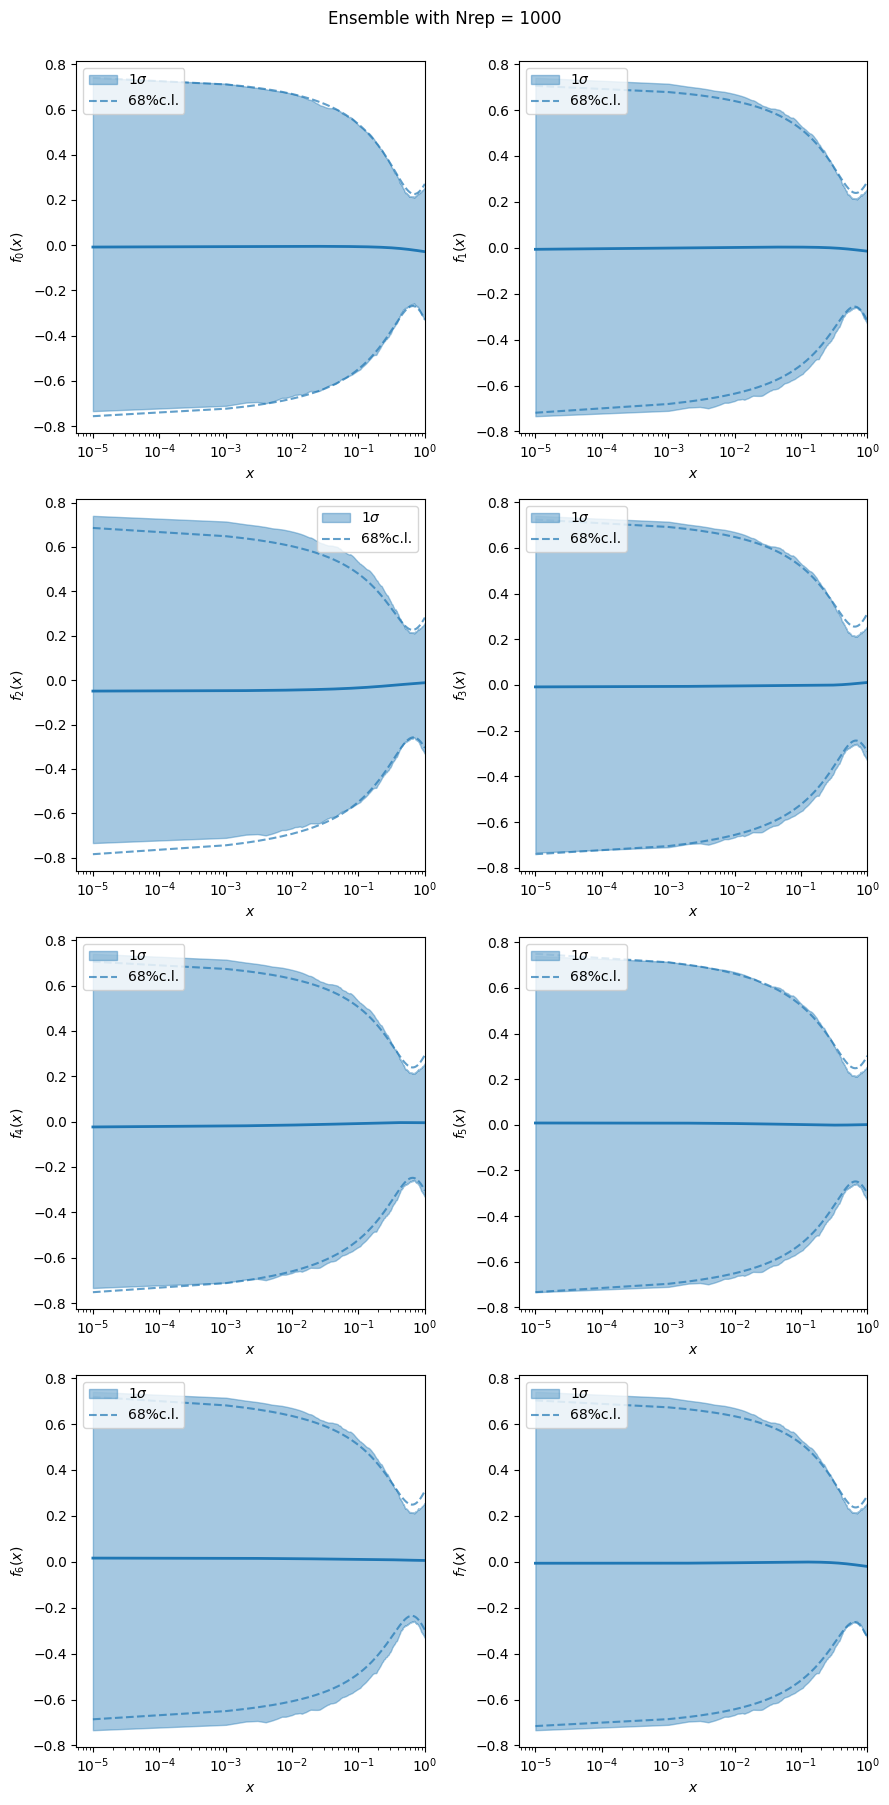

In [13]:
fig, axs= plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
color = "C0"

for id, ax in enumerate(axs.flatten()):

  pdf_cv = model_outputs[:,:,id].mean(axis=0)
  pdf_std = model_outputs[:,:,id].std(axis=0)
  cl_high = np.nanpercentile(model_outputs[:,:,0], 84, axis=0)
  cl_low = np.nanpercentile(model_outputs[:,:,0], 16, axis=0)

  # plot rep0 PDF
  ax.plot(input_x_logx[:,0], pdf_cv, color=color, lw=2)

  # 68%c.l. band
  ax.fill_between(input_x_logx[:,0], cl_low, cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

  # 1 std lines
  ax.plot(input_x_logx[:,0], (pdf_cv - pdf_std), alpha=0.7,ls="dashed", color=color)
  ax.plot(input_x_logx[:,0], (pdf_cv + pdf_std), alpha=0.7,ls="dashed", color=color, label="68%c.l.")

  ax.legend()

  ax.set_xscale("log")
  #ax.set_yscale('symlog')
  ax.set_xlabel(r"$x$")
  ax.set_ylabel(rf"$f_{id}(x)$")
  ax.set_xlim(0.0,1)

fig.suptitle(rf"Ensemble with Nrep = {number_of_networks}", y = 1)
fig.tight_layout()
fig.savefig('nnpdf_log_gloriot_normal.png')